## RFM & Cohort Analysis
This dataset contains all the transactions occurred for a year for a UK-based worldwide online retail shop, with customers from 30+ countries. Many customers of the company are wholesalers. Based on the business characteristic, I believe it worth to take a closer look at the fluctuations of sales trend throughout the year. Thus I am going to conduct a marketing analysis which includes Key Performance Index (KPI) check and RFM analysis in order to understand the business in a broad perspective as well as to get action plan ideas. After predicting Lifetime Value of each customer, I will perform customer segmentation based on their spending pattern. For the final step, marketing advice for each customer group will be followed.

### Table of Contents
1. Data Preprocessing
2. Exploratory Data Analysis
3. KPI Check as a Whole 
4. KPI (Cohort)
5. Customer Lifetime Value Prediction
6. Customer Segmentation
7. Conclusion

### Data Preprocessing

In [358]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
import re
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [359]:
df = pd.read_csv("data.csv")

In [360]:
# checking for duplicated rows 

df.drop_duplicates(inplace = True)

In [361]:
# missing data

df.dropna(subset = ['CustomerID'], inplace = True) # drop all missing IDs, since RFM analysis only can be performed with data categorized with ID. 
df['Description'].fillna('NO DATA', inplace = True)
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [362]:
# UnitPrice -> TotalPrice

df['TotalPrice'] = df['UnitPrice']*df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [363]:
# removing outliers: IQR method
 
Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)
IQR = Q3-Q1

df = df.drop(df[df['TotalPrice']<(Q1-1.5*IQR)].index)
df = df.drop(df[df['TotalPrice']>(Q3+ 1.5*IQR)].index)
df['TotalPrice'].describe()

# There are negative values under the UnitPrice column, which is to be removed most of the time. However I am not going to delete the rows. 
# The values are equivalent to debt by each customer, and their revenue should be deducted as such.

count    368666.000000
mean         11.754021
std           9.438399
min         -19.050000
25%           4.150000
50%          10.200000
75%          17.000000
max          43.000000
Name: TotalPrice, dtype: float64

In [364]:
df_order = df.copy()
df_order.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [365]:
df_order['CustomerID'] = df_order['CustomerID'].astype(int).astype(str)
df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])
df_order['InvoiceMonth'] = df_order['InvoiceDate'].dt.to_period('m')
df_order['InvoiceDay'] = df_order['InvoiceDate'].dt.day
df_order['InvoiceHour']=  df_order['InvoiceDate'].dt.hour

In [366]:
df_order.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,InvoiceDay,InvoiceHour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12,1,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,1,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12,1,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,1,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12,1,8


In [367]:
# user count per country

df_nunique = df_order.groupby('Country')['CustomerID'].nunique().sort_values(ascending= False).head(10).reset_index()
df_nunique

,Country,CustomerID
0,United Kingdom,3815
1,Germany,95
2,France,86
3,Spain,29
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,15
8,Finland,12
9,Austria,11


In [368]:
# total revenue per country

df_total = df_order.groupby('Country')['TotalPrice'].sum().sort_values(ascending= False).head(10).reset_index()
df_total

,Country,TotalPrice
0,United Kingdom,3717749.514
1,Germany,137591.600
2,France,126889.740
3,EIRE,104531.190
4,Spain,33148.300
5,Belgium,32363.080
6,Switzerland,28406.250
7,Portugal,20502.590
8,Norway,16210.170
9,Italy,13075.360


Given that United Kingdom takes the 1st place in user count and revenue (and the company is the UK based business), United Kingdom is the biggest market for the company, followed by Germany and France. We can now consider that most of our future analysis is regarding the top 3 markets.

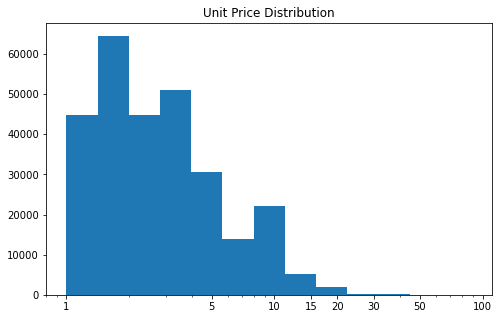

In [369]:
plt.figure(figsize = (8,5))
plt.hist(df_order['UnitPrice'], bins = 10** np.arange(0,2,0.15))
plt.xscale('log')
ticks = [1,5,10,15,20,30,50,100]
plt.xticks(ticks, ticks)
plt.title('Unit Price Distribution');

Given that most products cost less than $ 5, we can guess simple goods that could be used in daily life are mostly sold in the platform, rather than expensive goods.

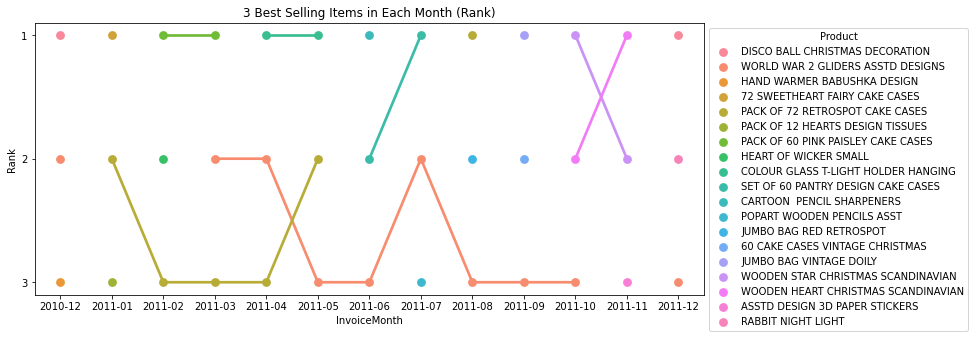

In [370]:
month_product_ds = df_order.groupby(['InvoiceMonth', 'Description'], as_index=False).agg({'Quantity':'sum'})
month_product_ds1 = month_product_ds.sort_values(by = 'Quantity', ascending = False)
month_product_ds1 = month_product_ds1.groupby('InvoiceMonth').nth([range(3)])
month_product_ds1['Rank'] = month_product_ds1.groupby('InvoiceMonth').rank()
month_product_ds1 = month_product_ds1.reset_index()

ax = plt.figure(figsize = (12,5))
ax = sns.pointplot(data = month_product_ds1, x = 'InvoiceMonth', y = 'Rank', hue = 'Description')
ax.invert_yaxis()
plt.legend(bbox_to_anchor=(1, 0., 0.3,1),title = 'Product')
plt.yticks([1,2,3])
plt.title('3 Best Selling Items in Each Month (Rank)');

- The change of demand greatly depends on the season, such as Wooden Christmas Scandinavian, Chstistmas Decoration, Hand Warmer on Autumn & Winter, Cake Cases from January to May, World War 2 Gliders from March to October (because of the not-so-cold weather). 
- I started to wonder if United Kingdom is the solely responsible for this trend, since UK is the country with the biggest number of user count and total revenue. 

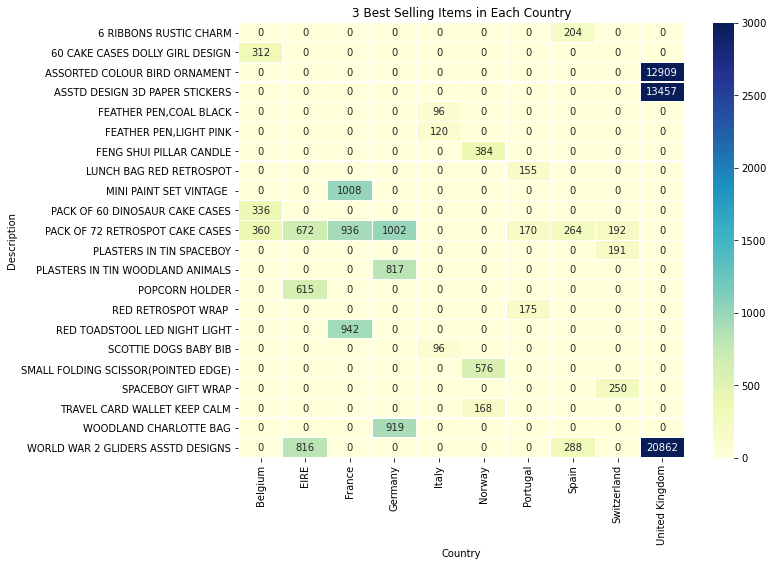

In [371]:
df_top_countries = df_order[df_order['Country'].isin(df_total.Country)]
month_product_ds = df_top_countries.groupby(['Country', 'Description']).agg({'Quantity':'sum'})
month_product_ds1 = month_product_ds.sort_values(by = 'Quantity', ascending = False).reset_index()
month_product_ds1 = month_product_ds1.groupby('Country').nth([range(3)]).reset_index()
df_top = month_product_ds1.pivot(index = 'Description', columns ='Country' , values = 'Quantity').fillna(0)

fig, ax = plt.subplots(figsize = (10,8))
ax = sns.heatmap(df_top, cmap = 'YlGnBu', annot=True, fmt="1.0f", vmax = 3000, linewidths = .1)
ax.set_title("3 Best Selling Items in Each Country");

- Each country has different best selling product, despite the fact that all country in the list share the similar European culture.
- UK customers are leading the overall ranking, which looks similar to what we've seen in the previous graph. Still, World War 2 Gliders and Pack of 72 Retrospot cake cases are popular among other countries as well. Maybe we can use this for marketing campaign for each country.

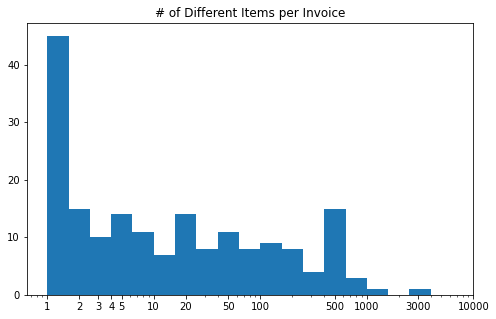

In [372]:
plt.figure(figsize = (8,5))
invoice_count = df_order.groupby('InvoiceNo')['StockCode'].nunique().value_counts()
plt.hist(invoice_count, bins = 10**np.arange(0,4,0.2))
plt.xscale('log')
ticks = [1,2,3,4,5,10,20,50,100, 500, 1000, 3000, 10000]
plt.xticks(ticks, ticks)
plt.title("# of Different Items per Invoice"); 

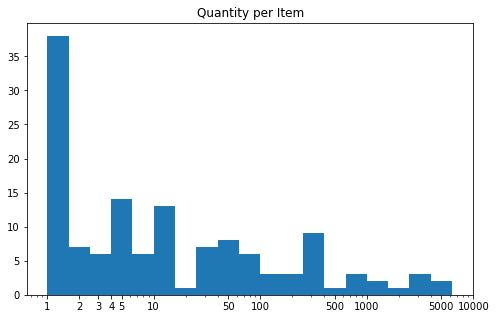

In [373]:
plt.figure(figsize = (8,5))
invoice_count = df_order.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().value_counts()
plt.hist(invoice_count, bins = 10**np.arange(0,4,0.2))
plt.xscale('log')
ticks = [1,2,3,4,5,10,50,100, 500, 1000, 5000, 10000]
plt.xticks(ticks, ticks)
plt.title('Quantity per Item');

Most purchases are done with small variety of products per invoice with small amount of item. This means our customers are mainly small sized wholesalers. 

I usually look into more details in ordered time and day for other analysis. But considering this company targets wholesalers worldwide, I don't think it would give much insights to check those information. However, I do think it's important to divide user activities by month because monthly revenues greatly fluctuate according to holidays. We are going to dig into main KPIs by month below.

### 2. KPI analysis

It's not always the best idea to list all KPIs available, as we only have limited resources and we are not able to improve all indexes at the same time. Therefore I am only going to focus following KPIs, including Monthly Order Count, Total Basket Size (=Monthly Revenue) and Average Revenue per Customer for the New , Existing customer group each.

Before we start, let us brieftly check what kind of customers we mostly have and how we should set our strategy with repurchase rate within 30 days. I have set it to be 30 days because we only have information less than a year.
Also, since the revenue earned from UK market takes the biggest portion of the whole revenue, I am only going to focus on UK.

In [374]:
df_order = df_order.query("Country == 'United Kingdom'")

df_order['InvoiceDate'] = pd.to_datetime(df_order['InvoiceDate'])
df_ninety = df_order.groupby('CustomerID').agg(NinetyDays= ('InvoiceDate', lambda row: row.min()+ pd.to_timedelta(30,'d')),
                                         MinDay = ('InvoiceDate', lambda row: row.min()+ pd.to_timedelta(6,'h')))
df_order = df_order.merge(df_ninety, on = 'CustomerID', how = 'left')

def ninety(x):
    if (x['InvoiceDate'] <= x['NinetyDays']) & (x['InvoiceDate'] > x['MinDay']):
        return 'Purchased'
    else:
        return 'Not Purchased'

df_order['ninety_TF'] = df_order.apply(ninety, axis = 1)

df_ninety = df_order[df_order['ninety_TF'] == 'Purchased']
round(df_ninety['CustomerID'].nunique() *100/df['CustomerID'].nunique(),2)

24.41

According to Lean Analytics by Alistair Croll and Benjamin Yoskovitz, a business with 30-days repurchase rate greater than 20% can be considered to have loyal customers. So is our business with the rate of 24.41%. We should have an opportunity to use this in the upcoming analysis.

We would like to understand the basic characteristics of the business with overall KPI analysis. Since this business is targetting wholesaler instead of individual users, we don't have any information on other factors that could affect sales. (e.g. UTC tagging, device, cart abandonment rate...) So I am going to focus on seasonality only. (this is a limitation of this analysis) Main factors that will be considered are ``holidays, weather and special events`` such as Cyber Monday, Black Friday. 

Below is the list of big events that will be considered in this analysis:
- April - Mother's day, Easter
- June - Father's day
- October - Diwali
- November - Black Friday
- December - Christmas

I have exclude Valentine's day, as the products sold in this company are mostly miscellaneous goods which are not very popular for Valentine's day. Hari Raya has been has been excluded as well, because Muslims accounted for less than 5% of the whole UK populations back in 2011.

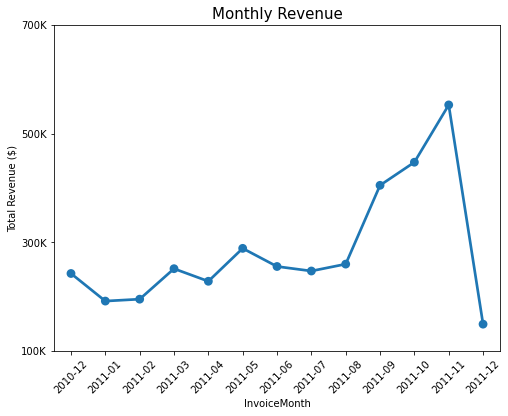

In [375]:
df_month = df_order.groupby(['InvoiceMonth'])['TotalPrice'].sum().reset_index()

plt.figure(figsize = (8,6))
sns.pointplot(data = df_month, x = 'InvoiceMonth', y = 'TotalPrice')
plt.xticks(rotation = 45)
plt.yticks([100000, 300000, 500000, 700000], labels = ['100K','300K','500K', '700K'])
plt.ylabel("Total Revenue ($)")
plt.title('Monthly Revenue', size = 15);

I have chosen Total Revenue as the first metric, because revenue gives general information of the business.
Before analysing the plot, do note the latest date of our dataset is 9 Dec 2011, which is less than a third of whole December. Even though it explains the sudden drop in December, the metric is going to slightly drop anyway comparing to the previous month. 
- Revenue made a huge increase at year end since September, due to many holidays and events including Diwali, Black Friday and Christmas. It is common to see a big increase in revenue after September in many other e-commerce platform.
- If the business is an usual e-commerce platform for general users, such as Amazon, we can expect the graph to soar on the month of events itselves. (e.g. March for Easter) However, since our targets are wholesaler who tend to purchase products earlier and then sell to general customers at a later date, they response to the events a month earlier. As soon as the event is over, revenue tends to fall. (exception: year end high season)
- After January when revenue shrinks due to post-holiday budget tightening, it gradually increasing since March, all the way until August. Especially May when customers start preparing for summer stuff, as the weather gets warmer.

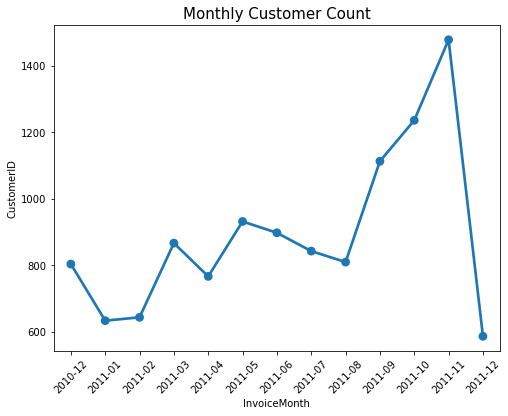

In [376]:
# monthly customer count 

df_monthly_sales = df_order.groupby('InvoiceMonth')['CustomerID'].nunique().reset_index()
plt.figure(figsize = (8,6))
sns.pointplot(data = df_monthly_sales, x = 'InvoiceMonth', y = 'CustomerID')
plt.title('Monthly Customer Count', size = 15)
plt.xticks(rotation =45);

I have chosen Customer count as the second metric to analyse, since it shows customers' engagement and interest in our business. If we have data regarding the customers who check on each product but eventually don't buy, we can calculate conversion rate which is one of the most important metrics in e-commerce business. 

- After the big holidays there are much lesser people make a purchase. (on January, February, April) This means most people are not very interested in shopping. Do note that we are not going to have a promotion on products that people don't even want, but on some daily necessities during these days.
- Lesser people make a purchase on mid-summer (July, Auguest), probably due to no events and no seaonal changes. We can consider maintaining customer engagement by having a discount on summer items, and throwing a marketing campaign on autumn stuffs.
- If we have more data on our customers' business, their customers' geographical information we should be able to learn any critical factors that could increase conversion rate.

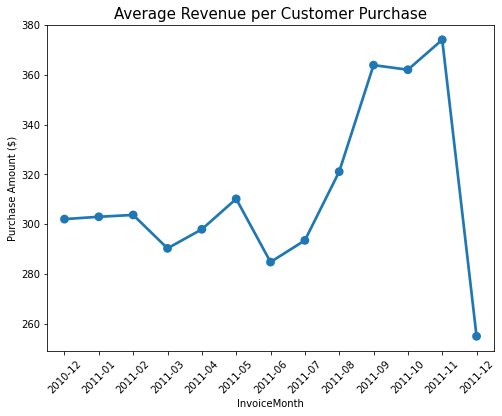

In [377]:
# Average revenue per customer purchase - the ultimate metric to be maximized, by increasing purchase amount and order count

df_customer_count = df_order.groupby('InvoiceMonth')['CustomerID'].nunique().reset_index()
df_price_sum = df_order.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
df_monthly_order_avg = pd.merge(df_price_sum, df_customer_count, on = 'InvoiceMonth', how = 'left')
df_monthly_order_avg['AvgSpending'] = df_monthly_order_avg['TotalPrice']/df_monthly_order_avg['CustomerID']

plt.figure(figsize = (8,6))
sns.pointplot(data = df_monthly_order_avg, x = 'InvoiceMonth', y = 'AvgSpending')
plt.xticks(rotation = 45)
plt.title('Average Revenue per Customer Purchase', size = 15)
plt.ylabel("Purchase Amount ($)");

Average revenue per customer helps us do health check of our business, because it is not heavily influenced by a small number of huge buyers.
- Average revenue per customer since September. Now we can confirm that not only number of customers but also average purchase amount increases during high season.
- Average purchase amount per customer is reversely propotional to customer count. We have to balance between these two metrics, in order to increase total revenue. If we only focus on increasing customer count, average revenue will decrease resulting in smaller total revenue. In the same context, I'm a bit concerned about the small number of customers on Jan, Feb and Aug. We can consider having a promotion to keep customers engaged.

In [378]:
# Monthly New user growth

df_min_purchase = df_order.groupby('CustomerID').InvoiceMonth.min().reset_index()
df_min_purchase.columns = ['CustomerID','minpurchasedate']
df_min_purchase['minpurchasedate'] = df_min_purchase['minpurchasedate'].map(lambda date: 100*date.year + date.month)

df_order = pd.merge(df_order, df_min_purchase, on='CustomerID')
df_order['usertype'] = 'New'
df_order['month_y'] = df_order['InvoiceMonth'].map(lambda date: 100*date.year + date.month)
df_order.loc[df_order['month_y']>df_order['minpurchasedate'],'usertype'] = 'Existing'

df_user_type_revenue = df_order.groupby(['month_y','usertype', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
df_user_type_revenue

,month_y,usertype,InvoiceMonth,TotalPrice
0,201012,New,2010-12,242802.780
1,201101,Existing,2011-01,99441.830
2,201101,New,2011-01,92616.090
3,201102,Existing,2011-02,101303.430
4,201102,New,2011-02,94259.970
5,201103,Existing,2011-03,137219.920
6,201103,New,2011-03,114412.880
7,201104,Existing,2011-04,146132.950
8,201104,New,2011-04,82358.511
9,201105,Existing,2011-05,222777.340


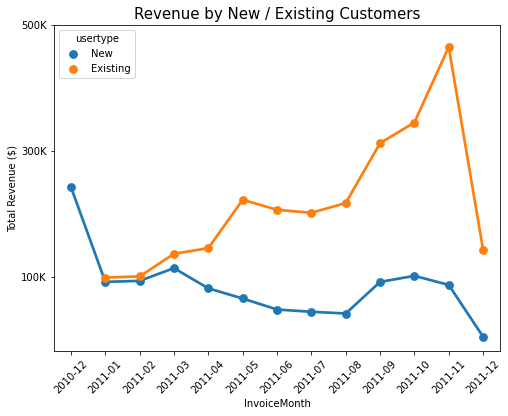

In [379]:
plt.figure(figsize = (8,6))
sns.pointplot(hue = 'usertype', data = df_user_type_revenue, x = 'InvoiceMonth', y = 'TotalPrice')
plt.xticks(rotation = 45)
plt.yticks([100000,300000, 500000], labels = ['100K', '300K','500K'])
plt.ylabel("Total Revenue ($)")
plt.title('Revenue by New / Existing Customers', size = 15);

- We can easily see that existing customer group is more profitable in terms of total revenue at every point of the year. This could be partly because of more existing customers than new users.
- As the peak season gets nearer total revenue increases in both group.

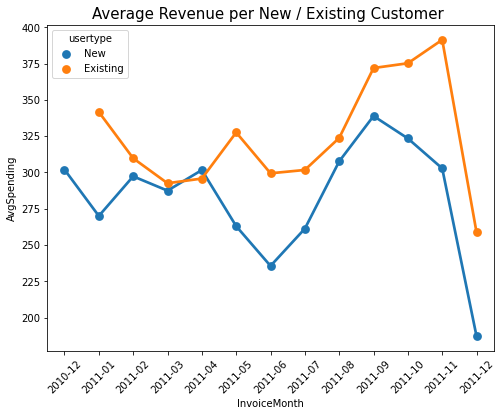

In [380]:
df_customer_count = df_order.groupby(['InvoiceMonth', 'usertype'])['CustomerID'].nunique().reset_index()
df_price_sum = df_order.groupby(['InvoiceMonth', 'usertype'])['TotalPrice'].sum().reset_index()
df_monthly_order_avg = pd.merge(df_price_sum, df_customer_count, on = ['InvoiceMonth', 'usertype'], how = 'left')
df_monthly_order_avg['AvgSpending'] = df_monthly_order_avg['TotalPrice']/df_monthly_order_avg['CustomerID']

plt.figure(figsize = (8,6))
sns.pointplot(data = df_monthly_order_avg, x = 'InvoiceMonth', y = 'AvgSpending', hue = 'usertype')
plt.xticks(rotation = 45)
plt.title("Average Revenue per New / Existing Customer ", size =15);

- Existing customers not only have bigger total revenue but also average revenue per person. This is probably because 1) loyal existing users 2) new customers tend to spend less on their first purchase, because they have no trust in our platform yet.
This proves one of our principles that focusing on existing customers is more profitable than acquiring new customers.

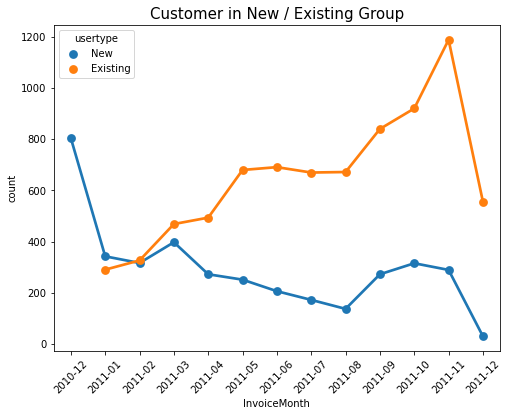

In [381]:
# New customer ratio

new_old = df_order.groupby(['InvoiceMonth','usertype'])['CustomerID'].nunique().reset_index(name = 'count')
plt.figure(figsize = (8,6))
sns.pointplot(data = new_old, x = 'InvoiceMonth', y = 'count', hue = 'usertype')
plt.xticks(rotation = 45)
plt.title("Customer in New / Existing Group", size = 15);

- Do you remember that the 30-days repurchase rate of our business was 24%? I simply mentioned that our business is maintained by loyal customers back then, but looking it back now I think the rate is partly because of few new customers incoming. 
- What concerns me most is that the number of new customers have been constantly decreasing. It slightly went up at year-end because of seasonality but the size didn't even reach Jan 2011. It seems we need an input from sales manager regarding this trend which is seemed to begin at 1st half of 2011. If we are considering to have a marketing promotion next year, we should try it only after fully understanding & fixing the issue.
- In contrast, I don't see anything noticeable with existing users' trend which has been increasing. We have already calculated that 30-day repurchase rate higher than 20%. This backs up the strong trend of increase.
- Many e-commerce companies choose to improve brand awareness throughout the year and acquire many new customers at year-end, just like our company. In order to set a marketing strategy for next year we need to understand how healthy our new customers are, since they will be a basis of next year's business. We need to break the customers down depending on cohorts they belong to. 

### 3. KPI Analysis (Cohort)
In order to understand our current performance and to set a future strategy, we need to break down newly acquired customers with their cohort. What I would like to focus on with this cohort analysis is below;
1) How long do customers in each cohort stick to our business? (= churn) 

2) How much do customers in each cohort purchase?

In [382]:
cohort = df_order.copy()
cohort['CohortMonth'] = cohort.groupby('CustomerID')['InvoiceMonth'].transform('min')

months = ['InvoiceMonth', 'CohortMonth']
for i in months:
    cohort[i] = cohort[i].dt.to_timestamp()
    
year_diff = cohort['InvoiceMonth'].dt.year - cohort['CohortMonth'].dt.year
month_diff = cohort['InvoiceMonth'].dt.month - cohort['CohortMonth'].dt.month
cohort['Months'] = year_diff*12 + month_diff + 1

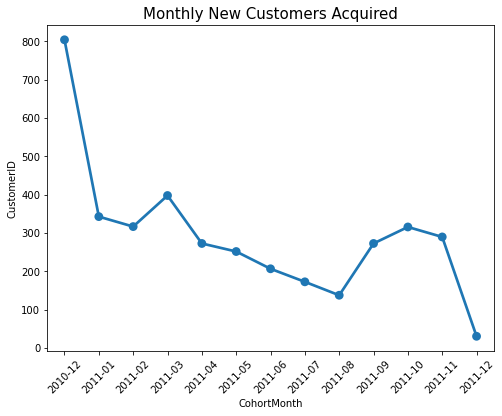

In [383]:
cohort_table = cohort.groupby(['CohortMonth', 'Months'])['CustomerID'].agg('nunique').reset_index()
cohort_table_1 = cohort_table[cohort_table['Months'] == 1]
cohort_table_1['CohortMonth'] = cohort_table_1['CohortMonth'].dt.to_period("m")

plt.figure(figsize = (8,6))
sns.pointplot(data = cohort_table_1, x = 'CohortMonth', y = 'CustomerID')
plt.xticks(rotation = 45)
plt.title("Monthly New Customers Acquired", size = 15);

- Here the cohort in 2010-12 might look like the healthiest, but we should keep in mind that our dataset starts at 2010-12. Which means all the customers who got acquired before 2010-12 have been categorized altogether.
- This plot exactly shows the issue that I have raised - new customer acquired is getting smaller. Not even maintaining the inflow level, after 2011-03 (for Easter).

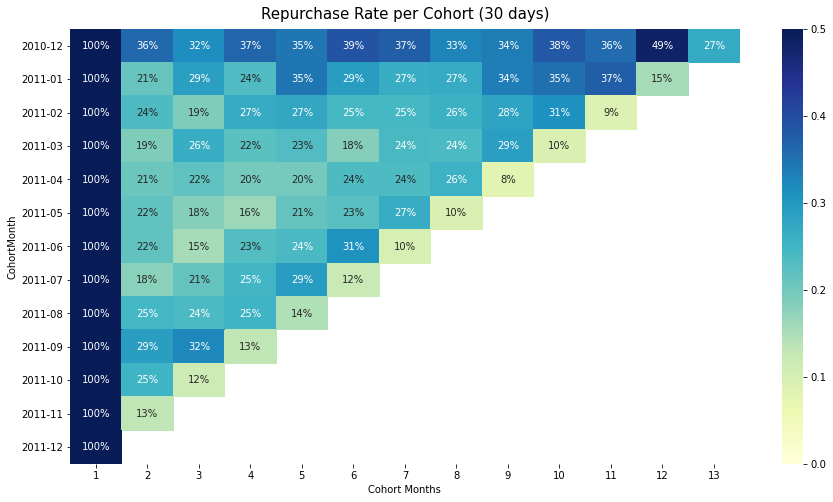

In [384]:
# Retention table (This table is usually made to calculate retention rate, but here I'm using for repurchase rate of each cohort)

cohort_count = pd.pivot_table(index = "CohortMonth", columns = "Months", values = "CustomerID", data = cohort_table)
calc_base = cohort_count.iloc[:,0]
retention = cohort_count.divide(calc_base, axis = 0)
retention.index = retention.index.strftime("%Y-%m")

plt.figure(figsize =(15,8))
sns.heatmap(data = retention, annot = True, fmt = '.0%', cmap = 'YlGnBu', vmin = 0.0,vmax = 0.5)
plt.title("Repurchase Rate per Cohort (30 days)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

- Do note that we only 1/3 of the data of the whole Decembember 2011!
- Seeing in diagonal, it seems the quality of customers who has first purchased during peak season (2011-09 onwards) are slightly better than those who purchased earlier. For example, 31% of people who first bought in 2011-02 came back for shopping in 2011-11. 
- The second cohort, 2011-01, has the highest repurchase rate among all. 

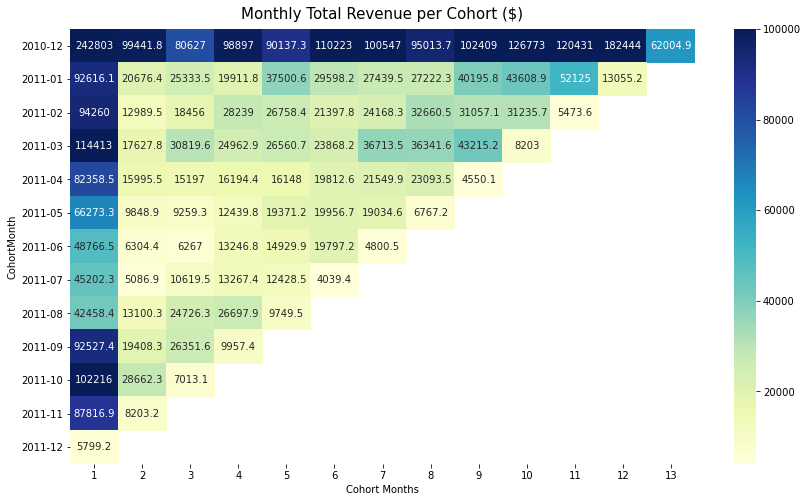

In [385]:
cohort_basket = cohort.groupby(['CohortMonth', 'Months'])['TotalPrice'].sum().reset_index()
cohort_basket_1 = pd.pivot_table(data = cohort_basket, index = "CohortMonth", columns = "Months", aggfunc = 'sum', values = "TotalPrice")
cohort_basket_1.index = cohort_basket_1.index.strftime('%Y-%m')
cohort_basket_1 = round(cohort_basket_1,1)

plt.figure(figsize = (14,8))
sns.heatmap(data = cohort_basket_1, annot = True, fmt = 'g', cmap = 'YlGnBu', vmax = 100000)
plt.title("Monthly Total Revenue per Cohort ($)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

- Total revenue for year-end is higher than usual. But considering this is the supposed to be the highest season, performance of this year-end is still not good enough.
- 2011-03 has the highest total revenue, since there was the biggest number of customer influx in 2011-03. Total revenue is naturally proportional to customer count
actually disappointing.

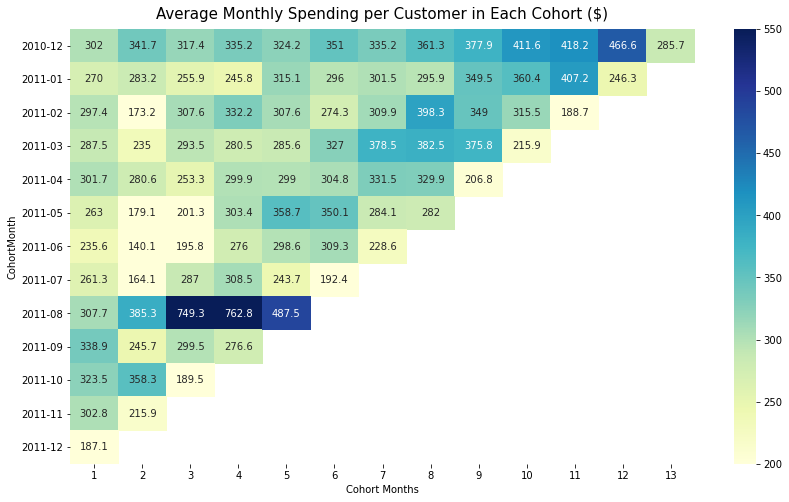

In [386]:
df_customer_count = cohort.groupby(['CohortMonth', 'Months'])['CustomerID'].nunique().reset_index()
df_price_sum = cohort.groupby(['CohortMonth', 'Months'])['TotalPrice'].sum().reset_index()
df_monthly_order_avg = pd.merge(df_price_sum, df_customer_count, on = ['CohortMonth', 'Months'], how = 'left')
df_monthly_order_avg['AvgAmt'] = df_monthly_order_avg['TotalPrice']/df_monthly_order_avg['CustomerID']
df_monthly_order_avg

# AvgAmt: average revenue by customer in each cohort & month 

cohort_avgamt = df_monthly_order_avg.groupby(['CohortMonth', 'Months'])['AvgAmt'].mean().reset_index()
cohort_avgamt_1 = pd.pivot_table(data = cohort_avgamt, index = "CohortMonth", columns = "Months", values = "AvgAmt")
cohort_avgamt_1.index = cohort_avgamt_1.index.strftime('%Y-%m')
cohort_avgamt_1 = round(cohort_avgamt_1,1)

plt.figure(figsize = (14,8))
sns.heatmap(data = cohort_avgamt_1, annot = True, fmt = 'g', cmap = 'YlGnBu', vmax = 550, vmin=200)
plt.title("Average Monthly Spending per Customer in Each Cohort ($)", size = 15, pad = 10)
plt.xlabel("Cohort Months");

- The cohort of 2011-08 has so much higher average revenue than other cohorts during the same period. This is because there was smaller number of customers first purchased in 2011-08, as shown in the acquisition plot.

Conclusion for new customers

- The cohort acquired in 2011-01 (and 2010-12) is the healthiest for the highest average revenue, total revenue and repurchase rate. Customers who first purchased in recent days didn't purchase as much as previous cohorts, even during holiday season. 
- Since the quality of newly acquired customers are getting worse even with higher demand at year-end, we need to consider setting a new strategy for customer acquisition for 2012 AFTER understanding the reason of continuous drop since 2011-04. 

Here, I have two hypothesis of the reason ;
1) Internal reason: Our products / platform is doesn't match people's demand or not good enough. In order to better understand what is going on, we need additional data such as funnel data, activity log, cart abandonment rate, recommendation system acceptance rate. Once we have fixed the issue, we can use viral strategy which is one of the most efficient way to advertise your business to the potential users. 

2) External reason (e.g. arise of new competitors): What's important is to get people to try our platform first, and then leads to the next purchase by offering coupons that people can use for nexst purchase. This will make users to be familiar with our service. (Details fully depends on our budget) We can offer a promotion such as bulk discount, discount of extra expense (e.g. shipping fee...), time limit discount to give ourselves price benefit.

After segmenting existing customers we are going to set a strategy for existing customers.

In [ ]:
### Customer Segmentation
We are now going to seperate existing users into multiple groups. (Customer Segmentation) These groups share the similar characteristics within the same group in terms of recency, frequency and monetary value. I am not going to consider customer lifetime value that we've predicted in the previous section, as in this dataset monetary value is equivalent to customer lifetime value. 

Since we have alrady calculated recency, frequency and monetary value of each customer I would like to start customer segmentation using K-means clustering method. This is useful when you only have continuous values.

There are two prerequisite of K-means clustering; 
1. All the columns should have the same mean, starndard variation and variance. Since K-means clustering method uses distance between different data points, we have to make sure that all the points have the same scale.
2. No column should be skewed. Skewed data will give you a skewed mean and distance, which could result in inaccurate analysis.

### Customer Lifetime Value Prediction
Before we move on to customer segmentation, since lifetime value 

In [387]:
from sklearn.model_selection import train_test_split
train_id, test_id = train_test_split(df_order['CustomerID'].unique(), test_size = 0.2, random_state = 42)
train_id, valid_id = train_test_split(train_id, test_size = 0.2, random_state = 42)
len(train_id), len(valid_id), len(test_id)

# In my first attempt I split users in train/valid/test group using month. But considering 1) spending pattern in high season differs from low season, and 2) users in train dataset appears in test dataset again, I decided to split them using ID in order to prevent data leakage.

(2441, 611, 763)

In [388]:
unique_train = df_order[df_order['CustomerID'].isin(train_id)]
unique_valid = df_order[df_order['CustomerID'].isin(valid_id)]
unique_test = df_order[df_order['CustomerID'].isin(test_id)]
unique_train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,InvoiceDay,InvoiceHour,NinetyDays,MinDay,ninety_TF,minpurchasedate,usertype,month_y
299,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,12.6,2010-12,1,8,2010-12-31 08:34:00,2010-12-01 14:34:00,Not Purchased,201012,New,201012
300,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,12.6,2010-12,1,8,2010-12-31 08:34:00,2010-12-01 14:34:00,Not Purchased,201012,New,201012
301,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047,United Kingdom,30.0,2010-12,1,8,2010-12-31 08:34:00,2010-12-01 14:34:00,Not Purchased,201012,New,201012
302,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047,United Kingdom,9.9,2010-12,1,8,2010-12-31 08:34:00,2010-12-01 14:34:00,Not Purchased,201012,New,201012
303,536367,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,2010-12-01 08:34:00,4.25,13047,United Kingdom,25.5,2010-12,1,8,2010-12-31 08:34:00,2010-12-01 14:34:00,Not Purchased,201012,New,201012


In [389]:
unique_train['InvoiceDate'] = pd.to_datetime(unique_train['InvoiceDate'])
perform_date = df_order['InvoiceDate'].max() + pd.to_timedelta(1,'d')
rfm_train= unique_train.groupby('CustomerID').agg({'InvoiceDate': lambda row: (perform_date - row.max()).days,
                                   'InvoiceNo': lambda row: row.nunique(),
                                    'TotalPrice':'sum'})
rfm_train.rename(columns = {'InvoiceDate':'recency', 'TotalPrice':'monetary_value', 'InvoiceNo':'frequency'}, inplace = True)

unique_valid['InvoiceDate'] = pd.to_datetime(unique_valid['InvoiceDate'])
rfm_valid= unique_valid.groupby('CustomerID').agg({'InvoiceDate': lambda row: (perform_date - row.max()).days,
                                   'InvoiceNo': lambda row: row.nunique(),
                                    'TotalPrice':'sum'})
rfm_valid.rename(columns = {'InvoiceDate':'recency', 'TotalPrice':'monetary_value', 'InvoiceNo':'frequency'}, inplace = True)

unique_test['InvoiceDate'] = pd.to_datetime(unique_test['InvoiceDate'])
rfm_test= unique_test.groupby('CustomerID').agg({'InvoiceDate': lambda row: (perform_date - row.max()).days,
                                   'InvoiceNo': lambda row: row.nunique(),
                                    'TotalPrice':'sum'})
rfm_test.rename(columns = {'InvoiceDate':'recency', 'TotalPrice':'monetary_value', 'InvoiceNo':'frequency'}, inplace = True)

rfm_train.shape, rfm_valid.shape, rfm_test.shape

((2441, 3), (611, 3), (763, 3))

- Recency: How many days have passed since each customer's latest purchase?
- Frequency: How many time has each customer purchased in a certain time frame? (1 year in this dataset) 
- Monetary Value: How much has each customer purchased at my business?
Greater numbers in frequency and monetary value demonstrate that the customer is loyal. In contrary, do note that high recency value means the customer hasn't purchased at all in a while, which is different from frequency and monetary value. 

In [390]:
unique_train_days = unique_train.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.max()- x.min()).dt.days+1
unique_valid_days = unique_valid.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.max()- x.min()).dt.days+1
unique_test_days = unique_test.groupby('CustomerID')['InvoiceDate'].apply(lambda x: x.max()- x.min()).dt.days+1

rfm_train['average_amount'] = rfm_train['monetary_value']/unique_train_days
rfm_valid['average_amount'] = rfm_valid['monetary_value']/unique_valid_days
rfm_test['average_amount'] = rfm_test['monetary_value']/unique_test_days
rfm_test

,recency,frequency,monetary_value,average_amount
CustomerID,,,,
12749,4,7,3489.08,16.614667
12820,3,4,942.34,2.908457
12836,59,4,2316.26,9.155178
12837,173,1,134.10,134.100000
12841,5,26,3613.56,9.819457
...,...,...,...,...
18260,173,8,2272.58,12.218172
18263,23,4,1211.08,5.265565
18269,366,1,168.60,168.600000


In [391]:
# First purchse month, year

rfm_train['min_month'] = unique_train.groupby('CustomerID')['InvoiceMonth'].min().dt.month
rfm_train['min_year'] = unique_train.groupby('CustomerID')['InvoiceMonth'].min().dt.year

rfm_valid['min_month'] = unique_valid.groupby('CustomerID')['InvoiceMonth'].min().dt.month
rfm_valid['min_year'] = unique_valid.groupby('CustomerID')['InvoiceMonth'].min().dt.year

rfm_test['min_month'] = unique_test.groupby('CustomerID')['InvoiceMonth'].min().dt.month
rfm_test['min_year'] = unique_test.groupby('CustomerID')['InvoiceMonth'].min().dt.year

rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year
CustomerID,,,,,,
12749,4,7,3489.08,16.614667,5,2011
12820,3,4,942.34,2.908457,1,2011
12836,59,4,2316.26,9.155178,2,2011
12837,173,1,134.10,134.100000,6,2011
12841,5,26,3613.56,9.819457,12,2010
...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010
18263,23,4,1211.08,5.265565,4,2011
18269,366,1,168.60,168.600000,12,2010


In [392]:
# spending pattern - hour

unique_train_hour = pd.DataFrame(unique_train.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_train_hour['hour'] = unique_train_hour['InvoiceDate'].dt.hour
unique_train_hour = unique_train_hour.groupby(['CustomerID', 'hour'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_hour")

unique_valid_hour = pd.DataFrame(unique_valid.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_valid_hour['hour'] = unique_valid_hour['InvoiceDate'].dt.hour
unique_valid_hour = unique_valid_hour.groupby(['CustomerID', 'hour'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_hour")

unique_test_hour = pd.DataFrame(unique_test.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_test_hour['hour'] = unique_test_hour['InvoiceDate'].dt.hour
unique_test_hour = unique_test_hour.groupby(['CustomerID', 'hour'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_hour")

rfm_train = pd.merge(rfm_train, unique_train_hour, on = 'CustomerID', how = 'left')
rfm_valid = pd.merge(rfm_valid, unique_valid_hour, on = 'CustomerID', how = 'left')
rfm_test = pd.merge(rfm_test, unique_test_hour, on = 'CustomerID', how = 'left')

rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour
CustomerID,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,4.0,1.0,13.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [393]:
# spending pattern - year

unique_train_year = pd.DataFrame(unique_train.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_train_year['year'] = unique_train_year['InvoiceDate'].dt.year
unique_train_year = unique_train_year.groupby(['CustomerID', 'year'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_year")

unique_valid_year = pd.DataFrame(unique_valid.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_valid_year['year'] = unique_valid_year['InvoiceDate'].dt.year
unique_valid_year = unique_valid_year.groupby(['CustomerID', 'year'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_year")

unique_test_year = pd.DataFrame(unique_test.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_test_year['year'] = unique_test_year['InvoiceDate'].dt.year
unique_test_year = unique_test_year.groupby(['CustomerID', 'year'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_year")

rfm_train = pd.merge(rfm_train, unique_train_year, on = 'CustomerID', how = 'left')
rfm_valid = pd.merge(rfm_valid, unique_valid_year, on = 'CustomerID', how = 'left')
rfm_test = pd.merge(rfm_test, unique_test_year, on = 'CustomerID', how = 'left')

rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,2010_year,2011_year
CustomerID,,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,...,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,...,13.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,7.0
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [394]:
# spending pattern - month

unique_train_month = pd.DataFrame(unique_train.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_train_month['month'] = unique_train_month['InvoiceDate'].dt.month
unique_train_month = unique_train_month.groupby(['CustomerID', 'month'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_month")

unique_valid_month = pd.DataFrame(unique_valid.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_valid_month['month'] = unique_valid_month['InvoiceDate'].dt.month
unique_valid_month = unique_valid_month.groupby(['CustomerID', 'month'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_month")

unique_test_month = pd.DataFrame(unique_test.groupby(['CustomerID','InvoiceDate'])['InvoiceHour'].count()).reset_index()
unique_test_month['month'] = unique_test_month['InvoiceDate'].dt.month
unique_test_month = unique_test_month.groupby(['CustomerID', 'month'])['InvoiceHour'].agg(len).unstack().fillna(0).add_suffix("_month")

rfm_train = pd.merge(rfm_train, unique_train_month, on = 'CustomerID', how = 'left')
rfm_valid = pd.merge(rfm_valid, unique_valid_month, on = 'CustomerID', how = 'left')
rfm_test = pd.merge(rfm_test, unique_test_month, on = 'CustomerID', how = 'left')

rfm_train

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,3_month,4_month,5_month,6_month,7_month,8_month,9_month,10_month,11_month,12_month
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,2,11,1959.01,5.337902,12,2010,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0
12748,1,211,23709.29,63.563780,12,2010,0.0,0.0,0.0,4.0,...,13.0,6.0,25.0,16.0,13.0,14.0,14.0,14.0,43.0,45.0
12821,214,1,92.72,92.720000,5,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12822,71,2,846.88,49.816471,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
12824,60,1,349.42,349.420000,10,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,74,1,173.90,173.900000,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18281,181,1,80.82,80.820000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18282,8,3,176.60,1.484034,8,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0


In [395]:
# Purchase pattern - day of week

unique_train['dayofweek'] = unique_train['InvoiceDate'].dt.dayofweek
unique_train_dayofweek = unique_train.groupby(['CustomerID', 'dayofweek'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_dayofweek')\

unique_valid['dayofweek'] = unique_valid['InvoiceDate'].dt.dayofweek
unique_valid_dayofweek = unique_valid.groupby(['CustomerID', 'dayofweek'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_dayofweek')

unique_test['dayofweek'] = unique_test['InvoiceDate'].dt.dayofweek
unique_test_dayofweek = unique_test.groupby(['CustomerID', 'dayofweek'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_dayofweek')

rfm_train = pd.merge(rfm_train, unique_train_dayofweek, on = 'CustomerID', how = 'left')
rfm_valid = pd.merge(rfm_valid, unique_valid_dayofweek, on = 'CustomerID', how = 'left')
rfm_test = pd.merge(rfm_test, unique_test_dayofweek, on = 'CustomerID', how = 'left')

rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,9_month,10_month,11_month,12_month,0_dayofweek,1_dayofweek,2_dayofweek,3_dayofweek,4_dayofweek,6_dayofweek
CustomerID,,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,93.0,80.0,0.0,51.0,0.0,0.0
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,25.0,12.0,22.0,0.0,0.0,0.0
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,23.0,85.0,61.0,0.0,0.0,0.0
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,...,1.0,4.0,2.0,3.0,48.0,0.0,87.0,113.0,49.0,131.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,25.0,34.0,36.0,11.0,3.0,25.0
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,0.0,16.0,0.0,1.0,30.0,15.0,0.0
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,0.0,0.0


In [396]:
# When do users usually purchase throughout the month? Begin, middle or end of the month?
# option 1. We can add all 31 days in full using pca of 5 columns. 
# option 2. We can divide 31 days into 3 parts, begin, middle and end of month.

unique_train['day'] = unique_train['InvoiceDate'].dt.day
unique_train_day = unique_train.groupby(['CustomerID', 'day'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_day')
unique_valid['day'] = unique_valid['InvoiceDate'].dt.day
unique_valid_day = unique_valid.groupby(['CustomerID', 'day'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_day')
unique_test['day'] = unique_test['InvoiceDate'].dt.day
unique_test_day = unique_test.groupby(['CustomerID', 'day'])['InvoiceDate'].agg(len).unstack().fillna(0).add_suffix('_day')

rfm_train['month_begin'] = unique_train_day.iloc[:,:10].sum(1) # axis=1
rfm_train['month_mid'] = unique_train_day.iloc[:,10:20].sum(1)
rfm_train['month_end'] = unique_train_day.iloc[:,20:].sum(1)
rfm_valid['month_begin'] = unique_valid_day.iloc[:,:10].sum(1) 
rfm_valid['month_mid'] = unique_valid_day.iloc[:,10:20].sum(1)
rfm_valid['month_end'] = unique_valid_day.iloc[:,20:].sum(1)
rfm_test['month_begin'] = unique_test_day.iloc[:,:10].sum(1) 
rfm_test['month_mid'] = unique_test_day.iloc[:,10:20].sum(1)
rfm_test['month_end'] = unique_test_day.iloc[:,20:].sum(1)
rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,12_month,0_dayofweek,1_dayofweek,2_dayofweek,3_dayofweek,4_dayofweek,6_dayofweek,month_begin,month_mid,month_end
CustomerID,,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,...,1.0,93.0,80.0,0.0,51.0,0.0,0.0,162.0,51.0,11.0
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,...,1.0,25.0,12.0,22.0,0.0,0.0,0.0,12.0,11.0,36.0
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,...,0.0,23.0,85.0,61.0,0.0,0.0,0.0,97.0,49.0,23.0
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,0.0
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,...,3.0,48.0,0.0,87.0,113.0,49.0,131.0,206.0,136.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,...,1.0,25.0,34.0,36.0,11.0,3.0,25.0,25.0,103.0,6.0
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,...,0.0,16.0,0.0,1.0,30.0,15.0,0.0,45.0,17.0,0.0
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0


In [397]:
# Do users regularly purchase on the same day of each month?

rfm_train['nunique_day'] = unique_train.groupby('CustomerID')['day'].nunique()
rfm_valid['nunique_day'] = unique_valid.groupby('CustomerID')['day'].nunique()
rfm_test['nunique_day'] = unique_test.groupby('CustomerID')['day'].nunique()
rfm_train

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,0_dayofweek,1_dayofweek,2_dayofweek,3_dayofweek,4_dayofweek,6_dayofweek,month_begin,month_mid,month_end,nunique_day
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,2,11,1959.01,5.337902,12,2010,0.0,0.0,1.0,1.0,...,11.0,29.0,18.0,20.0,0.0,6.0,41.0,19.0,24.0,10
12748,1,211,23709.29,63.563780,12,2010,0.0,0.0,0.0,4.0,...,336.0,543.0,1142.0,632.0,1032.0,681.0,1764.0,1065.0,1537.0,30
12821,214,1,92.72,92.720000,5,2011,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1
12822,71,2,846.88,49.816471,9,2011,0.0,0.0,0.0,0.0,...,0.0,37.0,0.0,0.0,8.0,0.0,0.0,37.0,8.0,2
12824,60,1,349.42,349.420000,10,2011,0.0,0.0,0.0,0.0,...,0.0,24.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,74,1,173.90,173.900000,9,2011,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1
18281,181,1,80.82,80.820000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0,0.0,1
18282,8,3,176.60,1.484034,8,2011,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,12.0,0.0,13.0,0.0,0.0,3


In [398]:
# Average unit price & have users purchased items with high price?

rfm_train[['unit_price_mean', 'unit_price_max']] = unique_train.groupby('CustomerID')['UnitPrice'].agg(['mean', 'max']) 
rfm_valid[['unit_price_mean', 'unit_price_max']] = unique_valid.groupby('CustomerID')['UnitPrice'].agg(['mean', 'max']) 
rfm_test[['unit_price_mean', 'unit_price_max']] = unique_test.groupby('CustomerID')['UnitPrice'].agg(['mean', 'max']) 
rfm_train

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,2_dayofweek,3_dayofweek,4_dayofweek,6_dayofweek,month_begin,month_mid,month_end,nunique_day,unit_price_mean,unit_price_max
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,2,11,1959.01,5.337902,12,2010,0.0,0.0,1.0,1.0,...,18.0,20.0,0.0,6.0,41.0,19.0,24.0,10,4.261786,15.95
12748,1,211,23709.29,63.563780,12,2010,0.0,0.0,0.0,4.0,...,1142.0,632.0,1032.0,681.0,1764.0,1065.0,1537.0,30,2.363706,29.95
12821,214,1,92.72,92.720000,5,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,1,2.498333,8.50
12822,71,2,846.88,49.816471,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,0.0,0.0,37.0,8.0,2,2.695778,14.95
12824,60,1,349.42,349.420000,10,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,24.0,0.0,1,2.310000,8.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,74,1,173.90,173.900000,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1,3.283333,4.95
18281,181,1,80.82,80.820000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,7.0,0.0,1,5.622857,16.95
18282,8,3,176.60,1.484034,8,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,13.0,0.0,0.0,3,4.821538,12.75


In [399]:
# Average purchase unit

rfm_train['product_count'] = unique_train.groupby('CustomerID')['Quantity'].mean()
rfm_valid['product_count'] = unique_valid.groupby('CustomerID')['Quantity'].mean()
rfm_test['product_count'] = unique_test.groupby('CustomerID')['Quantity'].mean()
rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,3_dayofweek,4_dayofweek,6_dayofweek,month_begin,month_mid,month_end,nunique_day,unit_price_mean,unit_price_max,product_count
CustomerID,,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,...,51.0,0.0,0.0,162.0,51.0,11.0,6,4.768125,14.95,6.111607
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,11.0,36.0,3,1.904746,4.95,12.237288
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,97.0,49.0,23.0,4,4.225858,16.95,5.917160
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,0.0,12.0,0.0,1,6.745833,16.95,2.000000
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,...,113.0,49.0,131.0,206.0,136.0,86.0,15,2.393014,16.95,5.880841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,...,11.0,3.0,25.0,25.0,103.0,6.0,8,3.707537,12.75,9.902985
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,...,30.0,15.0,0.0,45.0,17.0,0.0,4,0.977581,2.89,23.661290
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,1,3.164286,4.95,10.857143


In [400]:
# Average purchase amount

rfm_train['purchase_once'] = unique_train.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].agg('sum').groupby('CustomerID').mean()
rfm_valid['purchase_once'] = unique_valid.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].agg('sum').groupby('CustomerID').mean()
rfm_test['purchase_once'] = unique_test.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].agg('sum').groupby('CustomerID').mean()
rfm_train

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,4_dayofweek,6_dayofweek,month_begin,month_mid,month_end,nunique_day,unit_price_mean,unit_price_max,product_count,purchase_once
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,2,11,1959.01,5.337902,12,2010,0.0,0.0,1.0,1.0,...,0.0,6.0,41.0,19.0,24.0,10,4.261786,15.95,9.178571,178.091818
12748,1,211,23709.29,63.563780,12,2010,0.0,0.0,0.0,4.0,...,1032.0,681.0,1764.0,1065.0,1537.0,30,2.363706,29.95,4.361658,112.366303
12821,214,1,92.72,92.720000,5,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,0.0,0.0,1,2.498333,8.50,11.666667,92.720000
12822,71,2,846.88,49.816471,9,2011,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,37.0,8.0,2,2.695778,14.95,11.333333,423.440000
12824,60,1,349.42,349.420000,10,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.0,0.0,1,2.310000,8.25,9.416667,349.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,74,1,173.90,173.900000,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,1,3.283333,4.95,7.333333,173.900000
18281,181,1,80.82,80.820000,6,2011,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,7.0,0.0,1,5.622857,16.95,7.714286,80.820000
18282,8,3,176.60,1.484034,8,2011,0.0,0.0,0.0,0.0,...,12.0,0.0,13.0,0.0,0.0,3,4.821538,12.75,7.538462,58.866667


In [401]:
# Number of different items purchased

rfm_train['uniqueness'] = unique_train.groupby('CustomerID')['Description'].nunique()
rfm_valid['uniqueness'] = unique_valid.groupby('CustomerID')['Description'].nunique()
rfm_test['uniqueness'] = unique_test.groupby('CustomerID')['Description'].nunique()
rfm_train

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,6_dayofweek,month_begin,month_mid,month_end,nunique_day,unit_price_mean,unit_price_max,product_count,purchase_once,uniqueness
CustomerID,,,,,,,,,,,,,,,,,,,,,
12747,2,11,1959.01,5.337902,12,2010,0.0,0.0,1.0,1.0,...,6.0,41.0,19.0,24.0,10,4.261786,15.95,9.178571,178.091818,42
12748,1,211,23709.29,63.563780,12,2010,0.0,0.0,0.0,4.0,...,681.0,1764.0,1065.0,1537.0,30,2.363706,29.95,4.361658,112.366303,1758
12821,214,1,92.72,92.720000,5,2011,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,1,2.498333,8.50,11.666667,92.720000,6
12822,71,2,846.88,49.816471,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,37.0,8.0,2,2.695778,14.95,11.333333,423.440000,41
12824,60,1,349.42,349.420000,10,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,24.0,0.0,1,2.310000,8.25,9.416667,349.420000,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,74,1,173.90,173.900000,9,2011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,1,3.283333,4.95,7.333333,173.900000,9
18281,181,1,80.82,80.820000,6,2011,0.0,0.0,0.0,0.0,...,7.0,0.0,7.0,0.0,1,5.622857,16.95,7.714286,80.820000,7
18282,8,3,176.60,1.484034,8,2011,0.0,0.0,0.0,0.0,...,0.0,13.0,0.0,0.0,3,4.821538,12.75,7.538462,58.866667,12


In [402]:
# What kind of product users purchase often?

train_product = unique_train.groupby(['CustomerID', 'Description'])['TotalPrice'].agg(len).unstack().fillna(0)
valid_product = unique_valid.groupby(['CustomerID', 'Description'])['TotalPrice'].agg(len).unstack().fillna(0)
test_product = unique_test.groupby(['CustomerID', 'Description'])['TotalPrice'].agg(len).unstack().fillna(0)

from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
train_pca = pca.fit_transform(train_product)
valid_pca = pca.fit_transform(valid_product)
test_pca = pca.fit_transform(test_product)

for i in range(10):
    rfm_train[f'product_{i}'] = train_pca[:,i]
    rfm_valid[f'product_{i}'] = valid_pca[:,i]
    rfm_test[f'product_{i}'] = test_pca[:,i]
    
rfm_test

,recency,frequency,monetary_value,average_amount,min_month,min_year,6_hour,7_hour,8_hour,9_hour,...,product_0,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9
CustomerID,,,,,,,,,,,,,,,,,,,,,
12749,4,7,3489.08,16.614667,5,2011,0.0,0.0,0.0,1.0,...,1.231978,1.994130,4.213773,-3.428430,-4.896783,1.592862,0.227205,0.120756,-1.841247,0.333430
12820,3,4,942.34,2.908457,1,2011,0.0,0.0,0.0,0.0,...,-1.040112,-0.380437,-0.246429,0.123557,-0.036126,0.048151,-0.543175,0.066274,-0.131834,0.130436
12836,59,4,2316.26,9.155178,2,2011,0.0,0.0,0.0,0.0,...,1.378960,2.141054,1.225479,0.641632,-1.558377,-0.293976,0.991179,-1.090032,0.793859,0.502132
12837,173,1,134.10,134.100000,6,2011,0.0,0.0,0.0,0.0,...,-1.709181,-1.342271,-0.493770,0.564808,-0.199335,0.463038,-0.193749,-0.042116,0.205416,0.038978
12841,5,26,3613.56,9.819457,12,2010,0.0,0.0,0.0,0.0,...,6.089780,1.794167,3.479787,-5.760475,1.902892,0.328191,-2.049685,0.260730,-1.243606,-6.826689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18260,173,8,2272.58,12.218172,12,2010,0.0,0.0,0.0,0.0,...,0.459069,0.986732,1.718115,-2.447404,-2.288687,0.833380,0.035918,1.517862,-0.741890,0.439434
18263,23,4,1211.08,5.265565,4,2011,0.0,0.0,0.0,1.0,...,-1.339747,-1.226794,-0.529395,0.269146,0.345985,-0.552971,-0.242357,0.204308,0.137462,0.066597
18269,366,1,168.60,168.600000,12,2010,0.0,0.0,0.0,0.0,...,-1.856645,-1.445743,-0.606777,0.600163,0.135696,0.272609,-0.069886,-0.018713,0.083569,-0.084045


In [403]:
rfm_train = rfm_train.drop(columns = '20_hour')
rfm_valid = rfm_valid.drop(columns = '20_hour')
rfm_train.shape, rfm_valid.shape, rfm_test.shape 

((2441, 59), (611, 59), (763, 59))

In [404]:
rfm_train2 = rfm_train.drop(columns = 'monetary_value')
y_train = rfm_train['monetary_value']
rfm_valid2 = rfm_valid.drop(columns = 'monetary_value')
y_valid = rfm_valid['monetary_value']
rfm_test2 = rfm_test.drop(columns = 'monetary_value')
y_test = rfm_test['monetary_value']

In [405]:
# checking for missing values

rfm_train2.isnull().sum() 

recency            0
frequency          0
average_amount     0
min_month          0
min_year           0
6_hour             0
7_hour             0
8_hour             0
9_hour             0
10_hour            0
11_hour            0
12_hour            0
13_hour            0
14_hour            0
15_hour            0
16_hour            0
17_hour            0
18_hour            0
19_hour            0
2010_year          0
2011_year          0
1_month            0
2_month            0
3_month            0
4_month            0
5_month            0
6_month            0
7_month            0
8_month            0
9_month            0
10_month           0
11_month           0
12_month           0
0_dayofweek        0
1_dayofweek        0
2_dayofweek        0
3_dayofweek        0
4_dayofweek        0
6_dayofweek        0
month_begin        0
month_mid          0
month_end          0
nunique_day        0
unit_price_mean    0
unit_price_max     0
product_count      0
purchase_once      0
uniqueness   

In [406]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(verbose = 200)
cbr.fit(rfm_train2, y_train, eval_set = (rfm_valid2, y_valid), early_stopping_rounds = 30)

Learning rate set to 0.054543
0:	learn: 1765.4691999	test: 1235.4920901	best: 1235.4920901 (0)	total: 3.54ms	remaining: 3.53s
200:	learn: 187.8628066	test: 277.6541802	best: 277.6541802 (200)	total: 446ms	remaining: 1.77s
400:	learn: 75.8662253	test: 226.2091384	best: 226.2091384 (400)	total: 1s	remaining: 1.5s
600:	learn: 43.6974387	test: 217.2633265	best: 217.2633265 (600)	total: 1.65s	remaining: 1.09s
800:	learn: 28.7777929	test: 213.6665953	best: 213.6665953 (800)	total: 2.17s	remaining: 540ms
999:	learn: 20.2091961	test: 211.9073948	best: 211.8931853 (998)	total: 2.73s	remaining: 0us

bestTest = 211.8931853
bestIteration = 998

Shrink model to first 999 iterations.


In [407]:
from sklearn.metrics import mean_squared_error, r2_score
valid_prediction = cbr.predict(rfm_valid2)
ms = mean_squared_error(y_valid, valid_prediction)
r2 = r2_score(y_valid, valid_prediction)

In [408]:
print(ms)

44898.721029360066


In [409]:
r2 # r2 score is way too high which is suspected overfitting. we will need to check for overfitting at a later step

0.9723437692064956

In [411]:
# ms is higher than r2. this means our model is predicting well in general, but there are some rows that our prediction is quite different from actual values 
# what are the rows with the biggest difference?

test_check = pd.DataFrame(test_prediction)
test_check['test_true'] = y_test.values
test_check.columns = ['prediction', 'test_true']

test_check['error'] = test_check['prediction']- test_check['test_true']
test_check['error_abs'] = np.abs(test_check['error'])
test_check.sort_values(by = 'error_abs', ascending = False).head(10)

,prediction,test_true,error,error_abs
703,19165.617656,35375.36,-16209.742344,16209.742344
266,6711.391568,9820.67,-3109.278432,3109.278432
405,7983.851407,5028.42,2955.431407,2955.431407
290,6189.988238,8870.41,-2680.421762,2680.421762
314,6915.928384,9435.13,-2519.201616,2519.201616
704,2789.898713,4675.33,-1885.431287,1885.431287
160,2804.664429,4333.30,-1528.635571,1528.635571
35,2834.714267,1330.32,1504.394267,1504.394267
374,6616.553741,7938.11,-1321.556259,1321.556259
573,4486.007678,5729.63,-1243.622322,1243.622322


In [412]:
# checking for overfitting 1) feature importance 
 
pd.Series(cbr.feature_importances_, index = rfm_train2.columns).sort_values(ascending = False)

uniqueness         22.817468
product_0          10.977627
average_amount      9.812542
purchase_once       9.564945
2011_year           7.379523
frequency           7.006063
nunique_day         5.000256
month_begin         3.992257
product_count       3.878129
3_dayofweek         2.222673
0_dayofweek         1.994529
9_hour              1.799694
month_mid           1.734280
2_dayofweek         1.227183
month_end           0.882121
product_7           0.869529
14_hour             0.740852
1_dayofweek         0.719859
13_hour             0.633406
product_1           0.551529
10_hour             0.483553
5_month             0.475491
product_6           0.420030
9_month             0.414414
8_month             0.412897
unit_price_max      0.410160
4_dayofweek         0.374424
product_8           0.346325
2_month             0.321910
product_5           0.311578
3_month             0.297371
unit_price_mean     0.265644
product_3           0.247132
6_dayofweek         0.210013
12_month      

I don't see any column which is suspected to be overfitted column. (importance of 22.817 isn't that high) I can only tell that variety of purchased product matters in deciding customer lifetime value. 

In [414]:
from sklearn.metrics import mean_squared_error, r2_score
test_prediction = cbr.predict(rfm_test2)
ms = mean_squared_error(y_test, test_prediction)
r2 = r2_score(y_test, test_prediction)

In [415]:
print(ms)

429658.64980515186


In [416]:
r2

0.8638134439490182

In [417]:
# checking for overfitting 2) k-fold validation

rfm_all = pd.concat([rfm_train2,rfm_valid2])
y_all = pd.concat([y_train, y_valid])
rfm_all.shape, y_all.shape

((3052, 58), (3052,))

In [418]:
from sklearn.model_selection import KFold 
kf = KFold(n_splits = 5, random_state = 42, shuffle= True)

result_kf = 0
for train_index, valid_index in kf.split(rfm_all):
    x_train, x_valid = rfm_all.iloc[train_index], rfm_all.iloc[valid_index]
    y_train2, y_valid2 = y_all.iloc[train_index], y_all.iloc[valid_index]
    cbr = CatBoostRegressor(verbose = 200)
    cbr.fit(x_train, y_train2, eval_set = (x_valid, y_valid2), early_stopping_rounds = 30)
    valid_prediction = cbr.predict(x_valid) 
    ms = mean_squared_error(y_valid2, valid_prediction)
    r2 = r2_score(y_valid2, valid_prediction)
    result_kf += cbr.predict(rfm_test)/5
    print(r2)

Learning rate set to 0.054543
0:	learn: 1640.0348058	test: 1812.5755635	best: 1812.5755635 (0)	total: 3.51ms	remaining: 3.51s
200:	learn: 191.0967586	test: 839.3872035	best: 839.3872035 (200)	total: 445ms	remaining: 1.77s
400:	learn: 79.7740771	test: 794.9407476	best: 794.7854029 (398)	total: 931ms	remaining: 1.39s
600:	learn: 44.8218350	test: 790.2333536	best: 790.2333536 (600)	total: 1.5s	remaining: 997ms
800:	learn: 29.0714328	test: 789.0979886	best: 789.0901805 (797)	total: 2.05s	remaining: 509ms
Stopped by overfitting detector  (30 iterations wait)

bestTest = 788.8073054
bestIteration = 841

Shrink model to first 842 iterations.
0.8208565170450908
Learning rate set to 0.054543
0:	learn: 1766.1086183	test: 1224.5130834	best: 1224.5130834 (0)	total: 3.69ms	remaining: 3.69s
200:	learn: 186.4372779	test: 247.1468875	best: 247.1468875 (200)	total: 485ms	remaining: 1.93s
400:	learn: 74.0140811	test: 192.9366379	best: 192.8835906 (399)	total: 980ms	remaining: 1.46s
600:	learn: 40.650155

In [419]:
ms = mean_squared_error(y_test, result_kf)
r2 = r2_score(y_test, result_kf)

481922.3348879344


In [421]:
print(ms)

481922.3348879344


In [420]:
r2 

0.8472477090774286

Since r2 was pretty high, I have gone through a few steps to check whether our model is overfitted - feature importance, creating valid dataset and k-fold validation. I also made sure that we don't have the same customerIDs both in train and test dataset, which could lead to data leakage. There was no specific column that caused our model to be overfitted, and even after using more various data for train & test (valid dataset & k-fold validation) the score was still high. I can say for sure that the high score is not due to overfitting.

In [ ]:
# 테스트셋을 다르게 뽑을 수 있지 않을까. 여전히 80점대 이상일까.
# mape 
# 다른 모델을 써볼 수 있지 않을까.

### Customer Segmentation
We are now going to seperate existing users into multiple groups. (Customer Segmentation) These groups share the similar characteristics within the same group in terms of recency, frequency and monetary value. I am not going to consider customer lifetime value that we've predicted in the previous section, as in this dataset monetary value is equivalent to customer lifetime value. 

Since we have alrady calculated recency, frequency and monetary value of each customer I would like to start customer segmentation using K-means clustering method. This is useful when you only have continuous values.

There are two prerequisite of K-means clustering; 
1. All the columns should have the same mean, starndard variation and variance. Since K-means clustering method uses distance between different data points, we have to make sure that all the points have the same scale.
2. No column should be skewed. Skewed data will give you a skewed mean and distance, which could result in inaccurate analysis.

In [32]:
# replace negative values with positive values first

def remove_negative(x):
    if x <= 1:
        return 1
    else:
        return x
    
cols = ['recency', 'monetary_value', 'frequency']
for c in cols:
    rfm[c] = [remove_negative(x) for x in rfm[c]]

rfm_log = rfm[['recency', 'frequency', 'monetary_value']].apply(np.log, axis = 1)

In [33]:
# set all columns with the same scale with the same mean / std/ var using StandardScaler

scaler = StandardScaler()

rfm_normalized= scaler.fit_transform(rfm_log)
rfm_normalized = pd.DataFrame(rfm_normalized, index = rfm_log.index, columns = rfm_log.columns)
rfm_normalized.describe()

,recency,frequency,monetary_value
count,4.228000e+03,4.228000e+03,4.228000e+03
mean,-6.621572e-17,-7.727315e-17,-3.724551e-16
std,1.000118e+00,1.000118e+00,1.000118e+00
min,-2.573382e+00,-1.103066e+00,-4.519928e+00
25%,-6.240565e-01,-1.103066e+00,-5.756070e-01
50%,1.181932e-01,-3.551108e-01,2.337070e-02
75%,8.459810e-01,6.336326e-01,6.683661e-01
max,1.502663e+00,4.788218e+00,3.846110e+00


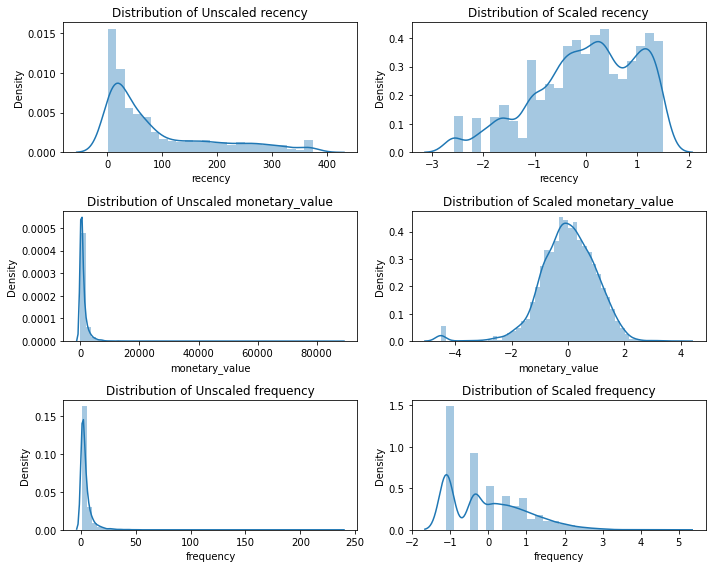

In [34]:
# checking whether our data is after scaling

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,8))
plt.subplots_adjust(right=1.5, top=1.25)

for i, c in enumerate(cols):
    sns.distplot(rfm[c],  hist=True, ax=ax[i][0])    
    sns.distplot(rfm_normalized[c], hist=True, ax=ax[i][1])
    ax[i][0].set_title(f'Distribution of Unscaled {c}')
    ax[i][1].set_title(f'Distribution of Scaled {c}')
    
plt.tight_layout()      
plt.show()

# It seems our dataset is much less skewed than before! 

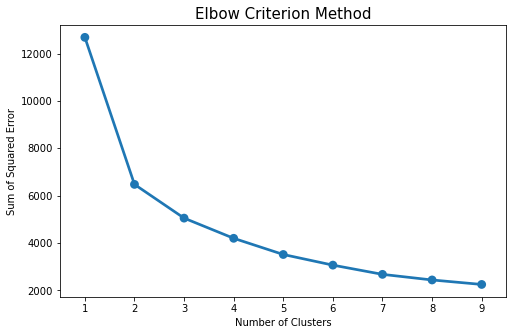

In [35]:
# choosing a number of clusters with elbow criterion method

sse = {}
for k in range (1,10):
    kmeans = KMeans(n_clusters =k, random_state = 42)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

plt.figure(figsize = (8,5))
plt.title('Elbow Criterion Method', size = 15)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Error')
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

In [36]:
# compute k-means clustering on pre-processed data

kc = KMeans(n_clusters=3, random_state=42)
kc.fit(rfm_normalized)

# extract the clustered labels

cluster_labels = kc.labels_
rfm_copy = rfm[['recency', 'frequency','monetary_value']]
rfm_kc = rfm_copy.assign(Cluster = cluster_labels)
rfm_kc= rfm_kc.replace({'Cluster': {2:'Low value', 0: 'Mid value', 1: 'High value'}})

# analyzing average RFM values of each cluster with a raw-data

rfm_groupby = rfm_kc.groupby('Cluster').agg({'recency': 'mean','frequency': 'mean',
                                         'monetary_value': ['mean', 'count']}).round(1)
rfm_groupby

recency frequency monetary_value      
              mean      mean           mean count
Cluster                                          
High value    11.9      13.6         3078.1   812
Low value    162.9       1.4          235.1  1785
Mid value     53.9       3.9          867.6  1631

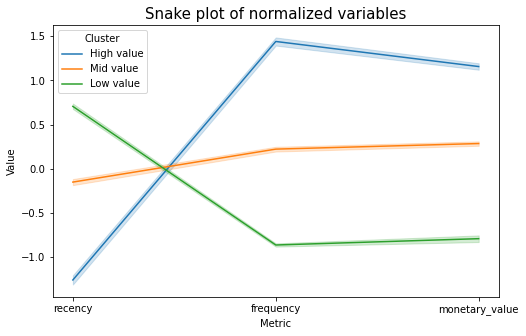

In [37]:
# build customer personas - snake plots

rfm_normalized = rfm_normalized.assign(Cluster = cluster_labels)
rfm_melt = pd.melt(rfm_normalized.reset_index(), id_vars = ['CustomerID', 'Cluster'], value_vars = ['recency', 'frequency', 'monetary_value'], var_name = 'metric',
                                                 value_name = 'value')

rfm_melt= rfm_melt.replace({'Cluster': {2:'Low value', 0: 'Mid value', 1: 'High value'}})
plt.figure(figsize = (8,5))
plt.title("Snake plot of normalized variables", size = 15)
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data= rfm_melt, x='metric', y='value', hue='Cluster');

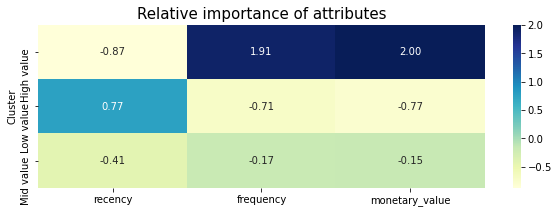

In [38]:
# relevant importance heatmap

cluster_avg = rfm_kc.groupby(['Cluster']).mean() 
population_avg = rfm_copy.mean()
relative_imp = cluster_avg / population_avg - 1

plt.figure(figsize=(10,3))
plt.title('Relative importance of attributes', size = 15)
sns.heatmap(data=relative_imp, annot=True, fmt='.2f',cmap='YlGnBu');

Our model has clustered all existing customers into 3 groups as below;
1) High value: Low recency, high frequency & monetary value. We usually call them VIP.

2) Mid value: Middle recency, frequency and monetary value. They need one more step to be a VIP, and we can help with a right marketing strategy.

3) Low value: High recency, low frequency & monetary value. These people are nearly hibernating, and almost going to churn.

According to our model, what distinguishes high value group from others is its high frequency and monetary value.
Low value group stands out with its high recency from all, which means these people haven't purchased our products long.

Conclusion for existing customers:
Our business mostly depends on loyal customers. This makes it even more important to divide existing customers, and apply different marketing strategy to each group based off their unique spending pattern.

1) High value: Offer special benefits only for VIPs. For monetary promotions, we can consider giving additional discount. Also, since their recency score is not very impressive, we can focus on encouraging them to visit us more often. (Detailed instructions to be discussed with marketing team) 

2) Mid value: They are just a few more steps away from VIP- which means they have already purchased many times and find our business match their demand at least a bit. We need to get them to purchase more, by sending email notification on discount information and distributing voucher only if they make a purchase more than certain amount.

3) Low value: Users in this group don't even find our business useful. If it's only been a few weeks since their last visit, We can try to make them visit us by sending an email, but with a slightly different message (e.g. We miss you! Do you want to check out our event for new members only for you?) In order for them to visit more frequently, we can consider stamp event they can earn everyday they log in, and use it as a mileage for their visit. But if they haven't visited for 6 months, I don't think it worth to use our budget to them, as they must have forgotten us.

Besides of this, we need to start analysing customer activity log of such as funnel data of VIPs, in order to discover how they find our platform useful from their behaviour. This could be very useful in understanding where we stand right now and improving product & market fit in future.

### Conclusion

This is a company with a typical business pattern at e-commerce whose metrics all rise sharply during year-end. Due to its high repurchase rate made by existing customers, it's important to maintain existing users in order to keep the business going. In order to expand business it's also important to acquire more customers. Given all metrics got worse since 2011-04, we need to  analyse customer behaviour data to understand the root cause of continuous drop, fix the issue and start a promotion for new customers. For existing customers, we can cluster them with similar spending pattern and apply different marketing strategies to each of them. 

###  Limitation of the analysis
- Not very comprehensive analysis due to insufficieint data we have. As we don't have any information on customer activities, it was impossible to dig deep where exactly we can improve.